<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=172865901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
from fastai.vision.all import *
from fastai.optimizer import Adam
import torchvision
path=Path("/kaggle/input/fvc2000-vcs-rehalf/dataset_ori")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: 
            t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]), cls

splits = RandomSplitter(seed=42)(files)
tfm = SiameseTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img
    

dls = tls.dataloaders(after_item=[Resize(160), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

#*aug_transforms()
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
#     def forward(self, x1, x2):
#         x1 = self.encoder(x1)
#         x2 = self.encoder(x2)
#         x1 = self.head(x1)
#         x2 = self.head(x2)
#         return x1, x2
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        return self.head(torch.cat([x1, x2], dim=1))

In [6]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        SiameseImage(x[0][i], x[1][i], f"Second_cls:{x[2][i].item()}").show(ctx=ctx)

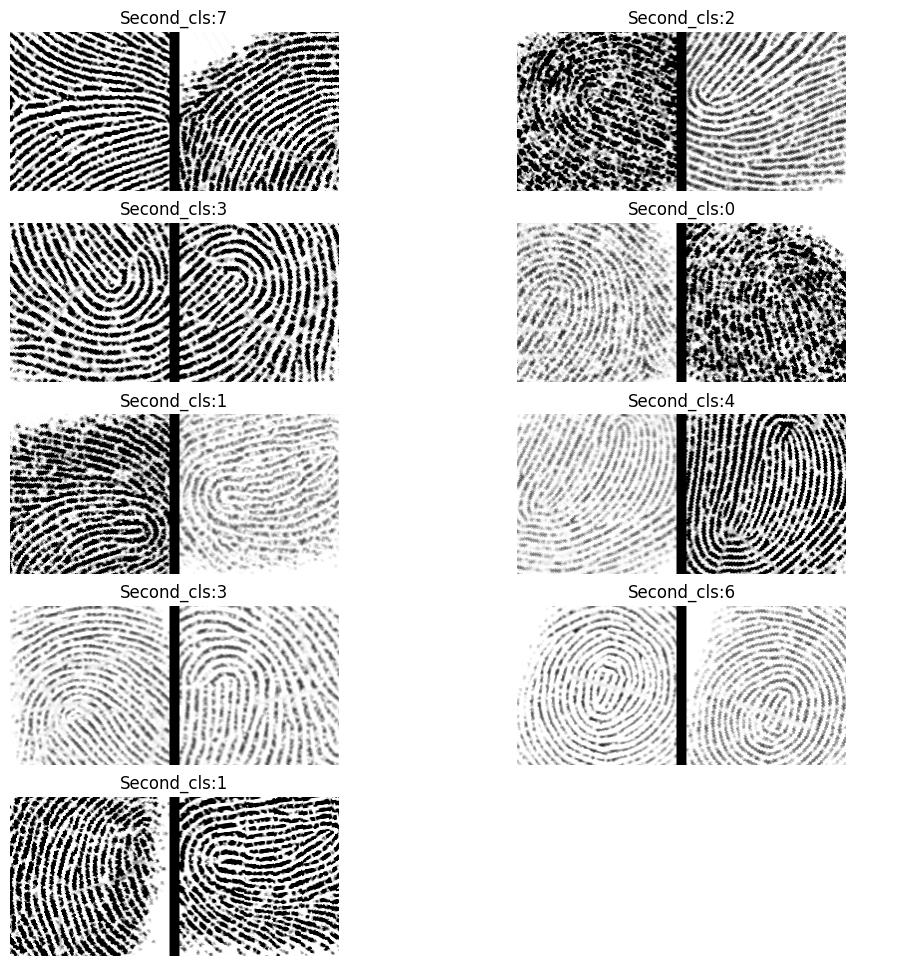

In [7]:
dls.show_batch()

In [8]:
EffNet=mobilenet_v2(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 135MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-1)
head = create_head(1280*2, 10, [1024, 256], ps=0.5, bn_final=True)
model = SiameseModel(encoder, head)

In [10]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [11]:
learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    splitter=siamese_splitter, 
    opt_func=Adam,
    metrics=[accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro'),RocAuc (average='macro')],
    cbs=[ShowGraphCallback, SaveModelCallback]
)

In [12]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.254472,0.533518,0.815625,0.856743,0.813378,0.818758,0.984554,00:07
1,0.947734,0.203202,0.946875,0.947904,0.948034,0.947387,0.998337,00:05


Better model found at epoch 0 with valid_loss value: 0.5335178375244141.


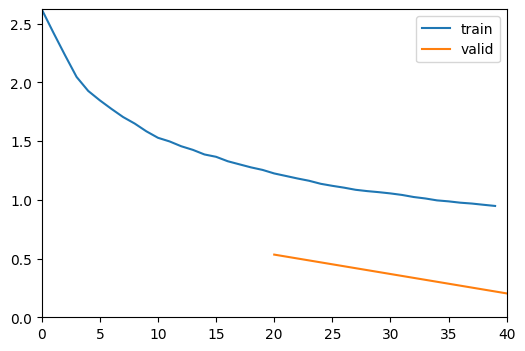

Better model found at epoch 1 with valid_loss value: 0.20320196449756622.


In [13]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.621351,0.180617,0.981250,0.982152,0.981516,0.981722,0.999301,00:06
1,0.553131,0.140973,0.987500,0.989167,0.987993,0.988420,0.999633,00:06
2,0.515959,0.161529,0.990625,0.991646,0.991118,0.991342,0.999874,00:06


Better model found at epoch 0 with valid_loss value: 0.18061667680740356.


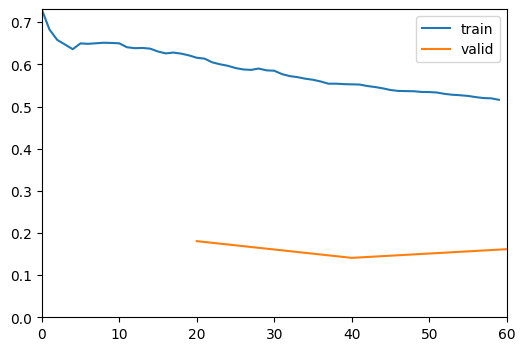

Better model found at epoch 1 with valid_loss value: 0.14097261428833008.


In [14]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3))

In [15]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {[x[2][i].item()]} \n Prediction: {[y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

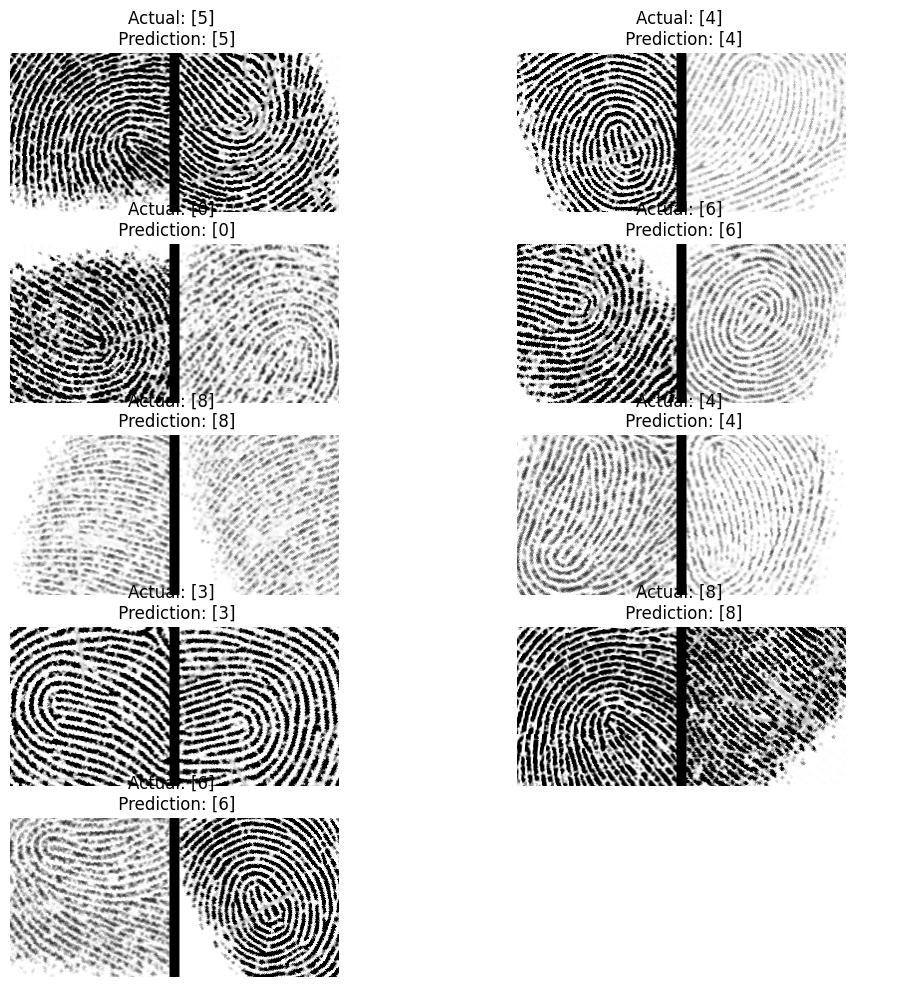

In [16]:
learn.show_results()

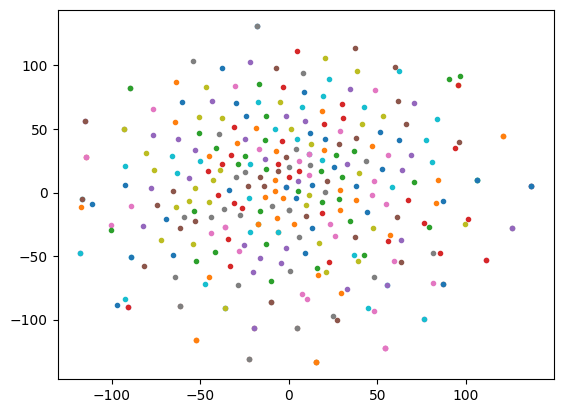

In [20]:
from sklearn.manifold import TSNE
hooks = Hooks(model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
#     print(i)
#     i.show()
    learn.model(i[0], i[1])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

In [ ]:
learn.export('EffNet_V2_M_nEVCS_128Emb.pkl')
#learn = load_learner('resnet50_lfw_gray.pkl', cpu=False)